In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, TensorDataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!cp -r ../input/features ../working

In [3]:
!ls

__notebook__.ipynb  features


In [4]:
!tar -xvzf features/features.tgz

._features
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
features/
features/._.DS_Store
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.FinderInfo'
features/.DS_Store
features/._test_nf.npy
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
features/test_nf.npy
features/._test_ef.npy
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.metadata:kMDItemWhereFroms'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
features/test_ef.npy
features/._train_sf.npy
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
features/train_sf.npy
features/._train_ef.npy

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Model(nn.Module):
    def __init__(self, inp_dim_nf=4800, inp_dim_ef=60, inp_dim_sf=10000, out_dim=4):
        super(Model, self).__init__()
        out_dim_nf = 100
        out_dim_ef = 50
        out_dim_sf = 50
        
        # Neural network for input Neural Features
        self.model_nf = nn.Sequential(
            nn.Linear(inp_dim_nf, 500),
            nn.Sigmoid(),
            nn.Dropout(0.2),
            nn.Linear(500, out_dim_nf),
            nn.Sigmoid()
        )

        # Neural network for input External Features
        self.model_ef = nn.Sequential(
            nn.Linear(inp_dim_ef, out_dim_ef),
            nn.ReLU()
        )
        
        # Neural network for input Statistical Features
        self.model_sf = nn.Sequential(
            nn.Linear(inp_dim_sf, 500),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(500, out_dim_sf),
            nn.ReLU()
        )

        # Feature Combined model
        self.fc = nn.Sequential(
            nn.BatchNorm1d(out_dim_nf + out_dim_ef + out_dim_sf),
            nn.Linear(out_dim_nf + out_dim_ef + out_dim_sf, out_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x_nf, x_ef, x_sf):
        h_nf = self.model_nf(x_nf)
        h_ef = self.model_ef(x_ef)
        h_sf = self.model_sf(x_sf)
        
        l2_reg_nf = torch.tensor(0.0).to(device)
        for name, param in self.model_nf.named_parameters():
            if 'weight' in name:
                l2_reg_nf += torch.norm(param, p=2)
        
        l2_reg_sf = torch.tensor(0.0).to(device)
        for name, param in self.model_sf.named_parameters():
            if 'weight' in name:
                l2_reg_sf += torch.norm(param, p=2)

        # Concatenate the outputs
        h = torch.cat((h_nf, h_ef, h_sf), dim=1)

        # Final prediction
        o = self.fc(h)

        return o, l2_reg_nf, l2_reg_sf

In [7]:
Xtr_nf = np.load('features/train_nf.npy')
Xtr_ef = np.load('features/train_ef.npy')
Xtr_sf = np.load('features/train_sf.npy')

LE = LabelEncoder()

df = pd.read_csv('../input/dataset/train.csv')
targets = LE.fit_transform(df['Stance'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [8]:
Xtr_nf.shape, Xtr_ef.shape, Xtr_sf.shape, targets.shape, type(targets) 

((49972, 4800), (49972, 60), (49972, 10000), (49972,), numpy.ndarray)

In [9]:
Xtr_nf = torch.from_numpy(Xtr_nf).float()
Xtr_ef = torch.from_numpy(Xtr_ef).float()
Xtr_sf = torch.from_numpy(Xtr_sf).float()
Ytr    = torch.from_numpy(targets)

print(type(Xtr_nf), type(Ytr), Ytr.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([49972])


In [10]:
train_dataset = TensorDataset(Xtr_nf, Xtr_ef, Xtr_sf, Ytr)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

In [11]:
model = Model(inp_dim_nf=4800, inp_dim_ef=60, inp_dim_sf=10000, out_dim=4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 10
lambda_reg_nf = 0.00000001  # Lambda for neural features
lambda_reg_sf = 0.00005  # Lambda for statistical features

for epoch in range(epochs):
    model.train()  # Set the model to train mode
    
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        x_nf, x_ef, x_sf, y = data
        x_nf, x_ef, x_sf, y = x_nf.to(device), x_ef.to(device), x_sf.to(device), y.to(device)
        optimizer.zero_grad()
        
        outputs, l2_reg_nf, l2_reg_sf = model(x_nf, x_ef, x_sf)
        classification_loss = loss_fn(outputs, y)
        
        # Compute regularization terms for neural and statistical features
        loss_nf = lambda_reg_nf * l2_reg_nf
        loss_sf = lambda_reg_sf * l2_reg_sf
        
        loss = classification_loss + loss_nf + loss_sf  # Add regularization terms to the loss
        
        loss.backward()
        optimizer.step()
            
        running_loss += classification_loss.item()

        # Print statistics every 'n' batches
        n = 100  # Adjust this value as needed
        if i % n == n - 1:  # Print every 'n' mini-batches
            print(f"Epoch [{epoch + 1}/{epochs}], Batch [{i + 1}/{len(train_loader)}], Loss: {running_loss / n}")
            running_loss = 0.0

print('Finished Training')

Epoch [1/10], Batch [100/500], Loss: 1.0111675536632538
Epoch [1/10], Batch [200/500], Loss: 0.8401983833312988
Epoch [1/10], Batch [300/500], Loss: 0.8273581355810166
Epoch [1/10], Batch [400/500], Loss: 0.8179621762037277
Epoch [1/10], Batch [500/500], Loss: 0.8089608383178711
Epoch [2/10], Batch [100/500], Loss: 0.8000144249200821
Epoch [2/10], Batch [200/500], Loss: 0.7954152232408523
Epoch [2/10], Batch [300/500], Loss: 0.7949531894922256
Epoch [2/10], Batch [400/500], Loss: 0.7948388642072678
Epoch [2/10], Batch [500/500], Loss: 0.7893914806842804
Epoch [3/10], Batch [100/500], Loss: 0.7845722031593323
Epoch [3/10], Batch [200/500], Loss: 0.7813153177499771
Epoch [3/10], Batch [300/500], Loss: 0.7816681468486786
Epoch [3/10], Batch [400/500], Loss: 0.7826367312669754
Epoch [3/10], Batch [500/500], Loss: 0.7848928779363632
Epoch [4/10], Batch [100/500], Loss: 0.7787611782550812
Epoch [4/10], Batch [200/500], Loss: 0.7785433787107467
Epoch [4/10], Batch [300/500], Loss: 0.776894614

In [13]:
!mkdir model

In [14]:
# Save the trained model
PATH = 'model/model.pth'
torch.save(model.state_dict(), PATH)

In [15]:
#loading the model
model = Model(inp_dim_nf=4800, inp_dim_ef=60, inp_dim_sf=10000, out_dim=4).to(device)
model.load_state_dict(torch.load('model/model.pth'))

<All keys matched successfully>

In [16]:
Xte_nf = np.load('features/test_nf.npy')
Xte_ef = np.load('features/test_ef.npy')
Xte_sf = np.load('features/test_sf.npy')

df = pd.read_csv('../input/dataset/test.csv')
targets = LE.transform(df['Stance'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [17]:
Xte_nf = torch.from_numpy(Xte_nf).float()
Xte_ef = torch.from_numpy(Xte_ef).float()
Xte_sf = torch.from_numpy(Xte_sf).float()
Yte    = torch.from_numpy(targets)

print(type(Xte_nf), type(Yte), Yte.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'> torch.Size([25413])


In [18]:
test_dataset = TensorDataset(Xte_nf, Xte_ef, Xte_sf, Yte)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [19]:
len(test_loader)

255

Classification Report:
              precision    recall  f1-score   support

       agree       0.48      0.41      0.44      1903
    disagree       0.00      0.00      0.00       697
     discuss       0.71      0.75      0.73      4464
   unrelated       0.95      0.99      0.97     18349

    accuracy                           0.88     25413
   macro avg       0.54      0.54      0.54     25413
weighted avg       0.85      0.88      0.86     25413



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


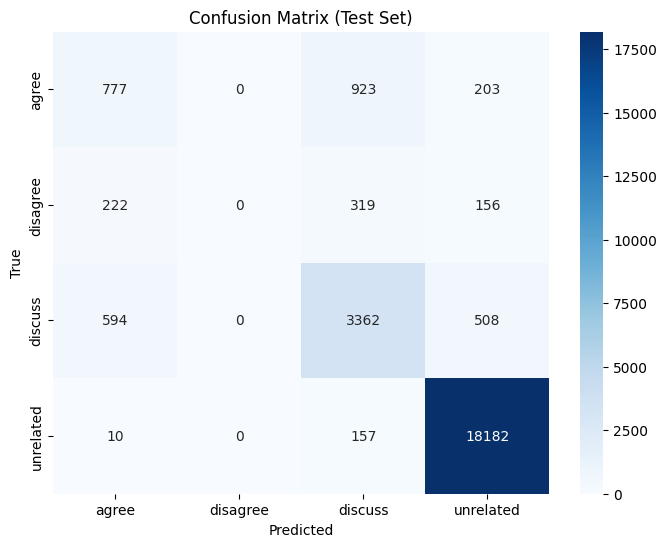

Accuracy: 0.8783299885885177
Average L2 regularization for Neural Features: 0.8700013974103858
Average L2 regularization for Statistical Features: 0.8943958437832592


In [20]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()  # Set the model to evaluation mode

y_true = []
y_pred = []
class_labels = ['agree', 'disagree', 'discuss', 'unrelated']
l2_reg_nf_total = 0.0
l2_reg_sf_total = 0.0

with torch.no_grad():
    for data in test_loader:  # Assuming you have a test dataloader
        x_nf, x_ef, x_sf, y = data
        x_nf, x_ef, x_sf, y = x_nf.to(device), x_ef.to(device), x_sf.to(device), y.to(device)
        
        out, l2_reg_nf, l2_reg_sf = model(x_nf, x_ef, x_sf)
        
        _, pred = torch.max(out, 1)
        
        y_pred.extend(pred.tolist())
        y_true.extend(y.tolist())
        
        l2_reg_nf_total += l2_reg_nf.item()
        l2_reg_sf_total += l2_reg_sf.item()

# Calculate metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm_test = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy}")

# Average L2 regularization terms across the test set
avg_l2_reg_nf = l2_reg_nf_total / len(test_loader.dataset)
avg_l2_reg_sf = l2_reg_sf_total / len(test_loader.dataset)

print(f"Average L2 regularization for Neural Features: {avg_l2_reg_nf}")
print(f"Average L2 regularization for Statistical Features: {avg_l2_reg_sf}")

In [21]:
accuracy_related_unrelated = accuracy_score([i for i in y_true if i != 3], [i for idx, i in enumerate(y_pred) if y_true[idx] != 3])
Score1 = accuracy_related_unrelated

accuracy_agree_disagree_discuss = accuracy_score([i for i in y_true if i != 3], [i for idx, i in enumerate(y_pred) if y_true[idx] != 3])
Score2 = accuracy_agree_disagree_discuss

ScoreFNC = 0.25 * Score1 + 0.75 * Score2
ScoreFNC

0.5859286523216308